<a href="https://colab.research.google.com/github/YanjunLin-Andrie/elan_price_prediction/blob/main/ELAN_future_weeks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
import tensorflow as tf
import yfinance as yf
from yahoo_fin.stock_info import get_data
import pandas as pd
import numpy as np
import pandas_datareader
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [103]:
#get all ELAN trading history until today from yahoo finance
df = get_data('ELAN', index_as_date = True, interval = '1wk').drop(columns = 'ticker')
df

,open,high,low,close,adjclose,volume
2018-09-17,32.250000,36.009998,32.049999,34.099998,34.099998,49452200
2018-09-24,34.099998,37.610001,33.700001,34.889999,34.889999,16028100
2018-10-01,35.480000,35.480000,32.709999,34.340000,34.340000,10334300
2018-10-08,34.000000,34.950001,31.760000,32.580002,32.580002,6534000
2018-10-15,32.490002,32.930000,31.330000,31.610001,31.610001,6136800
...,...,...,...,...,...,...
2022-06-27,20.809999,20.910000,19.340000,20.620001,20.620001,24564300
2022-07-04,20.250000,20.910000,20.030001,20.450001,20.450001,13488200
2022-07-11,20.250000,20.500000,19.110001,20.080000,20.080000,14734000
2022-07-18,20.090000,20.330000,19.930000,20.000000,20.000000,2536900


In [104]:
# Defines function to split X and y data
def window_data(df, window, feature_col_number, target_col_number):
    # Creates empty X and y list
    X = []
    y = []
    # loops through data
    for i in range(len(df) - window - 1):
        # splits the features by grouping window amount of previous close data
        features = df.iloc[i:(i + window), feature_col_number]
        # splits target by taking current close values
        target = df.iloc[(i + window), target_col_number]
        # Adds end of each loops data to respective X and y list
        X.append(features)
        y.append(target)
    # returns X,y as arrays
    return np.array(X), np.array(y).reshape(-1, 1)

In [105]:
# Defines window size
window_size=10

In [106]:
# Runs function to split X and y data
X, y=window_data(df, window_size, 3, 3)
# Displays X and y
display(X)
display(y)

array([[34.09999847, 34.88999939, 34.34000015, ..., 34.45999908,
        34.        , 33.61000061],
       [34.88999939, 34.34000015, 32.58000183, ..., 34.        ,
        33.61000061, 33.40999985],
       [34.34000015, 32.58000183, 31.61000061, ..., 33.61000061,
        33.40999985, 33.56999969],
       ...,
       [25.30999947, 23.79000092, 22.27000046, ..., 20.54999924,
        20.61000061, 20.62000084],
       [23.79000092, 22.27000046, 24.27000046, ..., 20.61000061,
        20.62000084, 20.45000076],
       [22.27000046, 24.27000046, 23.87000084, ..., 20.62000084,
        20.45000076, 20.07999992]])

array([[33.40999985],
       [33.56999969],
       [32.36999893],
       [30.        ],
       [31.31999969],
       [31.82999992],
       [31.95999908],
       [31.52000046],
       [30.60000038],
       [29.45000076],
       [29.69000053],
       [29.60000038],
       [29.19000053],
       [31.03000069],
       [29.39999962],
       [30.63999939],
       [32.72000122],
       [32.06999969],
       [33.11999893],
       [32.56999969],
       [31.11000061],
       [32.72000122],
       [32.13000107],
       [33.29999924],
       [33.04000092],
       [32.09999847],
       [31.28000069],
       [32.68999863],
       [31.95000076],
       [33.72999954],
       [33.79999924],
       [34.18999863],
       [33.31000137],
       [32.5       ],
       [33.15999985],
       [32.88999939],
       [30.64999962],
       [29.36000061],
       [26.40999985],
       [26.02000046],
       [27.35000038],
       [28.68000031],
       [27.53000069],
       [26.39999962],
       [26.78000069],
       [26

In [107]:
# Scales X and y data using MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X)
X_scaled=X_scaler.transform(X)
y_scaler=MinMaxScaler()
y_scaler.fit(y)
y_scaled=y_scaler.transform(y)

In [108]:
# Defines where train and test data will be split (70% is train)
split=int(0.7*len(X_scaled))
# Splits train and test data
X_train=X_scaled[:split]
X_test=X_scaled[split:]
y_train=y_scaled[:split]
y_test=y_scaled[split:]

In [109]:
#X_scaled=X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
#display(X.shape)

In [110]:
# Reshapes data into size LSTM can handle
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
display(X_train.shape)
display(X_test.shape)

(133, 10, 1)

(58, 10, 1)

In [111]:
# Creates neural network
model=Sequential()
# Defines and adds LSTM layer
first_lstm_layer=LSTM(units=30, return_sequences=True, input_shape=(window_size, 1))
model.add(first_lstm_layer)
# Randomly drops 20% of defined nodes
first_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model.add(first_dropout_layer)
second_lstm_layer=LSTM(units=30, return_sequences=True)
model.add(second_lstm_layer)
# Randomly drops 20% of defined nodes
second_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model.add(second_dropout_layer)
third_lstm_layer=LSTM(units=30)
model.add(third_lstm_layer)
# Defines and adds output layer with linear activation
output_layer=Dense(units=1, activation='linear')
model.add(output_layer)

In [112]:
# Compiles model
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [113]:
# Provides summary of model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 10, 30)            3840      
                                                                 
 dropout_10 (Dropout)        (None, 10, 30)            0         
                                                                 
 lstm_16 (LSTM)              (None, 10, 30)            7320      
                                                                 
 dropout_11 (Dropout)        (None, 10, 30)            0         
                                                                 
 lstm_17 (LSTM)              (None, 30)                7320      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trai

In [114]:
# Initially fits model using training data
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
5/5 [==============================] - 5s 16ms/step - loss: 0.3972 - mean_squared_error: 0.3972
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2599 - mean_squared_error: 0.2599
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1222 - mean_squared_error: 0.1222
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 0.0352 - mean_squared_error: 0.0352
Epoch 5/50
5/5 [==============================] - 0s 26ms/step - loss: 0.0569 - mean_squared_error: 0.0569
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 0.0307 - mean_squared_error: 0.0307
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 9/50
5/5 [==============================] - 0s 24ms/step - loss: 0.0291 - mean_squared_error: 0.0291
Epoch 10/50
5/5 [====================

In [115]:
# Projects future data by using model to predict next close and then uses that value to retrain 
# the model before making next prediction
for i in range(56): 
    # predicts next close value and reshapes it
    prediction_scaled=model.predict(X_train[-1].reshape(1, window_size, 1))
    # transforms prediction back to original scale
    next_prediction=y_scaler.inverse_transform(prediction_scaled)
    # displays predicted close value
    display(next_prediction)
    # adds predicted close value to list
    new_train_sample=np.append(X_train[-1], prediction_scaled)[1:].reshape(1, window_size, 1)
    # adds new list entry of predicted close to X train
    X_train=np.append(X_train, new_train_sample, axis=0)
    # adds new list entry of predicted close to y train
    y_train=np.append(y_train, prediction_scaled, axis=0)
    # refits model with new close value
    model.fit(X_train, y_train, epochs=5)

array([[31.018404]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 35ms/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 2/5
5/5 [==============================] - 0s 31ms/step - loss: 0.0223 - mean_squared_error: 0.0223
Epoch 3/5
5/5 [==============================] - 0s 27ms/step - loss: 0.0217 - mean_squared_error: 0.0217
Epoch 4/5
5/5 [==============================] - 0s 30ms/step - loss: 0.0218 - mean_squared_error: 0.0218
Epoch 5/5
5/5 [==============================] - 0s 28ms/step - loss: 0.0222 - mean_squared_error: 0.0222


array([[31.297218]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 30ms/step - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 2/5
5/5 [==============================] - 0s 37ms/step - loss: 0.0226 - mean_squared_error: 0.0226
Epoch 3/5
5/5 [==============================] - 0s 28ms/step - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 4/5
5/5 [==============================] - 0s 25ms/step - loss: 0.0224 - mean_squared_error: 0.0224
Epoch 5/5
5/5 [==============================] - 0s 31ms/step - loss: 0.0205 - mean_squared_error: 0.0205


array([[31.979933]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 33ms/step - loss: 0.0227 - mean_squared_error: 0.0227
Epoch 2/5
5/5 [==============================] - 0s 30ms/step - loss: 0.0213 - mean_squared_error: 0.0213
Epoch 3/5
5/5 [==============================] - 0s 33ms/step - loss: 0.0225 - mean_squared_error: 0.0225
Epoch 4/5
5/5 [==============================] - 0s 33ms/step - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 5/5
5/5 [==============================] - 0s 26ms/step - loss: 0.0221 - mean_squared_error: 0.0221


array([[32.090954]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 34ms/step - loss: 0.0211 - mean_squared_error: 0.0211
Epoch 2/5
5/5 [==============================] - 0s 41ms/step - loss: 0.0216 - mean_squared_error: 0.0216
Epoch 3/5
5/5 [==============================] - 0s 32ms/step - loss: 0.0201 - mean_squared_error: 0.0201
Epoch 4/5
5/5 [==============================] - 0s 37ms/step - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 5/5
5/5 [==============================] - 0s 28ms/step - loss: 0.0209 - mean_squared_error: 0.0209


array([[31.53026]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 45ms/step - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 2/5
5/5 [==============================] - 0s 27ms/step - loss: 0.0217 - mean_squared_error: 0.0217
Epoch 3/5
5/5 [==============================] - 0s 26ms/step - loss: 0.0215 - mean_squared_error: 0.0215
Epoch 4/5
5/5 [==============================] - 0s 27ms/step - loss: 0.0223 - mean_squared_error: 0.0223
Epoch 5/5
5/5 [==============================] - 0s 29ms/step - loss: 0.0205 - mean_squared_error: 0.0205


array([[31.936348]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 41ms/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 2/5
5/5 [==============================] - 0s 44ms/step - loss: 0.0200 - mean_squared_error: 0.0200
Epoch 3/5
5/5 [==============================] - 0s 34ms/step - loss: 0.0195 - mean_squared_error: 0.0195
Epoch 4/5
5/5 [==============================] - 0s 31ms/step - loss: 0.0200 - mean_squared_error: 0.0200
Epoch 5/5
5/5 [==============================] - 0s 30ms/step - loss: 0.0200 - mean_squared_error: 0.0200


array([[31.866653]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 40ms/step - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 2/5
5/5 [==============================] - 0s 33ms/step - loss: 0.0185 - mean_squared_error: 0.0185
Epoch 3/5
5/5 [==============================] - 0s 26ms/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 4/5
5/5 [==============================] - 0s 24ms/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 5/5
5/5 [==============================] - 0s 25ms/step - loss: 0.0195 - mean_squared_error: 0.0195


array([[31.985687]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 37ms/step - loss: 0.0185 - mean_squared_error: 0.0185
Epoch 2/5
5/5 [==============================] - 0s 26ms/step - loss: 0.0188 - mean_squared_error: 0.0188
Epoch 3/5
5/5 [==============================] - 0s 32ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 4/5
5/5 [==============================] - 0s 34ms/step - loss: 0.0189 - mean_squared_error: 0.0189
Epoch 5/5
5/5 [==============================] - 0s 23ms/step - loss: 0.0166 - mean_squared_error: 0.0166


array([[31.057312]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 25ms/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 2/5
5/5 [==============================] - 0s 37ms/step - loss: 0.0177 - mean_squared_error: 0.0177
Epoch 3/5
5/5 [==============================] - 0s 35ms/step - loss: 0.0178 - mean_squared_error: 0.0178
Epoch 4/5
5/5 [==============================] - 0s 22ms/step - loss: 0.0186 - mean_squared_error: 0.0186
Epoch 5/5
5/5 [==============================] - 0s 28ms/step - loss: 0.0182 - mean_squared_error: 0.0182


array([[31.077768]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 26ms/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 2/5
5/5 [==============================] - 0s 29ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 3/5
5/5 [==============================] - 0s 38ms/step - loss: 0.0165 - mean_squared_error: 0.0165
Epoch 4/5
5/5 [==============================] - 0s 37ms/step - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 5/5
5/5 [==============================] - 0s 43ms/step - loss: 0.0169 - mean_squared_error: 0.0169


array([[31.393219]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 30ms/step - loss: 0.0172 - mean_squared_error: 0.0172
Epoch 2/5
5/5 [==============================] - 0s 24ms/step - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 3/5
5/5 [==============================] - 0s 25ms/step - loss: 0.0186 - mean_squared_error: 0.0186
Epoch 4/5
5/5 [==============================] - 0s 29ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 5/5
5/5 [==============================] - 0s 31ms/step - loss: 0.0168 - mean_squared_error: 0.0168


array([[31.805155]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 24ms/step - loss: 0.0179 - mean_squared_error: 0.0179
Epoch 2/5
5/5 [==============================] - 0s 27ms/step - loss: 0.0152 - mean_squared_error: 0.0152
Epoch 3/5
5/5 [==============================] - 0s 34ms/step - loss: 0.0149 - mean_squared_error: 0.0149
Epoch 4/5
5/5 [==============================] - 0s 31ms/step - loss: 0.0166 - mean_squared_error: 0.0166
Epoch 5/5
5/5 [==============================] - 0s 28ms/step - loss: 0.0163 - mean_squared_error: 0.0163


array([[30.894695]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 15ms/step - loss: 0.0162 - mean_squared_error: 0.0162
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 3/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0153 - mean_squared_error: 0.0153
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 5/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0148 - mean_squared_error: 0.0148


array([[31.20881]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0162 - mean_squared_error: 0.0162
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0150 - mean_squared_error: 0.0150
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0155 - mean_squared_error: 0.0155
Epoch 4/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0155 - mean_squared_error: 0.0155
Epoch 5/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0135 - mean_squared_error: 0.0135


array([[30.67032]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0157 - mean_squared_error: 0.0157
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0149 - mean_squared_error: 0.0149
Epoch 4/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0155 - mean_squared_error: 0.0155
Epoch 5/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0146 - mean_squared_error: 0.0146


array([[30.670456]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 15ms/step - loss: 0.0155 - mean_squared_error: 0.0155
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 4/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 5/5
5/5 [==============================] - 0s 21ms/step - loss: 0.0134 - mean_squared_error: 0.0134


array([[31.069845]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0142 - mean_squared_error: 0.0142
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 5/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0134 - mean_squared_error: 0.0134


array([[30.991829]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 2/5
5/5 [==============================] - 0s 15ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 3/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0138 - mean_squared_error: 0.0138
Epoch 5/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0128 - mean_squared_error: 0.0128


array([[30.890495]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 2/5
5/5 [==============================] - 0s 20ms/step - loss: 0.0134 - mean_squared_error: 0.0134
Epoch 3/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 4/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 5/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0127 - mean_squared_error: 0.0127


array([[30.82687]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 2/5
5/5 [==============================] - 0s 21ms/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 5/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0124 - mean_squared_error: 0.0124


array([[30.706451]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 3/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 5/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0120 - mean_squared_error: 0.0120


array([[30.934916]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 3/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 5/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0109 - mean_squared_error: 0.0109


array([[30.969812]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 4/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 5/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0122 - mean_squared_error: 0.0122


array([[30.74735]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 5/5
5/5 [==============================] - 0s 21ms/step - loss: 0.0129 - mean_squared_error: 0.0129


array([[30.683594]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 4/5
5/5 [==============================] - 0s 15ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 5/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0100 - mean_squared_error: 0.0100


array([[30.541893]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 3/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 5/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0105 - mean_squared_error: 0.0105


array([[30.747972]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 2s 14ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 2/5
5/5 [==============================] - 0s 11ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 3/5
5/5 [==============================] - 0s 12ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 4/5
5/5 [==============================] - 0s 12ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 5/5
5/5 [==============================] - 0s 12ms/step - loss: 0.0097 - mean_squared_error: 0.0097


array([[30.997356]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 2/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 3/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0149 - mean_squared_error: 0.0149
Epoch 4/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0144 - mean_squared_error: 0.0144


array([[30.48518]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 4/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0133 - mean_squared_error: 0.0133


array([[30.374666]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 3/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 4/5
6/6 [==============================] - 0s 15ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 5/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0101 - mean_squared_error: 0.0101


array([[30.628248]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 3/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 5/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0106 - mean_squared_error: 0.0106


array([[30.913403]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 2/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 5/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0084 - mean_squared_error: 0.0084


array([[31.313717]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 2/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 3/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 4/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0086 - mean_squared_error: 0.0086


array([[31.27887]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 3/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 4/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 5/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0081 - mean_squared_error: 0.0081


array([[30.807194]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 2/5
6/6 [==============================] - 0s 15ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 3/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 4/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 5/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0091 - mean_squared_error: 0.0091


array([[30.82908]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 5/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0092 - mean_squared_error: 0.0092


array([[31.282434]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 2/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 5/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0080 - mean_squared_error: 0.0080


array([[30.998264]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 3/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 5/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0080 - mean_squared_error: 0.0080


array([[30.881018]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 3/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0076 - mean_squared_error: 0.0076


array([[31.238861]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0072 - mean_squared_error: 0.0072


array([[31.477217]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 3/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 4/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0069 - mean_squared_error: 0.0069


array([[31.10027]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 3/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 4/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0076 - mean_squared_error: 0.0076


array([[31.293024]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0058 - mean_squared_error: 0.0058


array([[30.833015]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 4/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 5/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0072 - mean_squared_error: 0.0072


array([[30.881292]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063


array([[30.425001]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 4/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064


array([[31.047207]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0073 - mean_squared_error: 0.0073


array([[30.912859]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064


array([[31.469494]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 2/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0067 - mean_squared_error: 0.0067


array([[31.89129]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059


array([[31.661516]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0070 - mean_squared_error: 0.0070


array([[31.380444]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063


array([[30.922508]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 3/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 5/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0062 - mean_squared_error: 0.0062


array([[30.534676]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056


array([[30.742481]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 2/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 3/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 4/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 5/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0060


array([[30.914528]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 3/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 4/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 5/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0060 - mean_squared_error: 0.0060


In [116]:
# predicts next close values
prediction = model.predict(X_test)
# rescales predicted values to original scale
y_predicted=y_scaler.inverse_transform(prediction)

In [117]:
len(df)

202

In [118]:
len(prediction)

58

In [119]:
len(df) - len(prediction)

144

In [120]:
comparison_df = pd.DataFrame({'predictions':y_predicted.ravel(),'actual':df.iloc[144:]['close']})
comparison_df
#display(y_predicted)
#display(df.iloc[760:]['close'])

,predictions,actual
2021-06-21,32.815453,35.040001
2021-06-28,34.146427,34.939999
2021-07-05,34.380753,34.639999
2021-07-12,34.031372,34.259998
2021-07-19,33.696766,36.500000
2021-07-26,33.401535,36.470001
2021-08-02,35.774689,35.360001
2021-08-09,35.310661,31.000000
2021-08-16,33.840504,31.500000
2021-08-23,29.631077,33.310001


In [121]:
len(comparison_df)

58

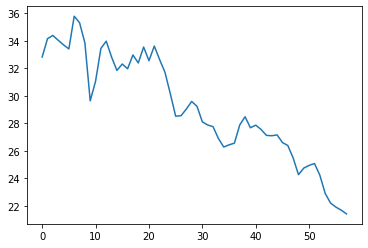

In [122]:
# Plots the predicted test values
plt.plot(y_predicted)
# Plots the true historic close values

(array([737972., 738034., 738095., 738156., 738215., 738276., 738337.]),
 <a list of 7 Text major ticklabel objects>)

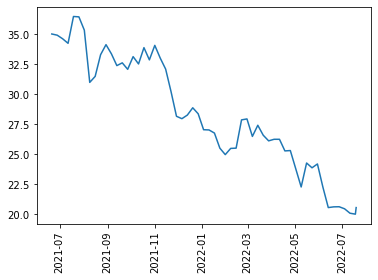

In [123]:
# Plots the true historic close values
plt.plot(df.iloc[144:]['close'])
# Rotates X labels
plt.xticks(rotation = 90)

In [124]:
# Begins Future Projections Section

In [125]:
# Creates neural network
model_prediction=Sequential()
# Defines and adds LSTM layer
first_lstm_layer=LSTM(units=30, return_sequences=True, input_shape=(window_size, 1))
model_prediction.add(first_lstm_layer)
# Randomly drops 20% of defined nodes
first_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model_prediction.add(first_dropout_layer)
second_lstm_layer=LSTM(units=30, return_sequences=True)
model_prediction.add(second_lstm_layer)
# Randomly drops 20% of defined nodes
second_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model_prediction.add(second_dropout_layer)
third_lstm_layer=LSTM(units=30)
model_prediction.add(third_lstm_layer)
# Defines and adds output layer with linear activation
output_layer=Dense(units=1, activation='linear')
model_prediction.add(output_layer)

In [126]:
# Compiles model
model_prediction.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [127]:
# Provides summary of model
model_prediction.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 30)            3840      
                                                                 
 dropout_12 (Dropout)        (None, 10, 30)            0         
                                                                 
 lstm_19 (LSTM)              (None, 10, 30)            7320      
                                                                 
 dropout_13 (Dropout)        (None, 10, 30)            0         
                                                                 
 lstm_20 (LSTM)              (None, 30)                7320      
                                                                 
 dense_6 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trai

In [128]:
X_scaled=X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
display(X.shape)

(191, 10)

In [129]:
# Initially fits model using training data
model_prediction.fit(X_scaled, y_scaled, epochs=50)

Epoch 1/50
6/6 [==============================] - 5s 23ms/step - loss: 0.3133 - mean_squared_error: 0.3133
Epoch 2/50
6/6 [==============================] - 0s 23ms/step - loss: 0.1299 - mean_squared_error: 0.1299
Epoch 3/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0441 - mean_squared_error: 0.0441
Epoch 4/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0467 - mean_squared_error: 0.0467
Epoch 5/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0296 - mean_squared_error: 0.0296
Epoch 6/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0348 - mean_squared_error: 0.0348
Epoch 7/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0272 - mean_squared_error: 0.0272
Epoch 8/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0269 - mean_squared_error: 0.0269
Epoch 9/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0262 - mean_squared_error: 0.0262
Epoch 10/50
6/6 [====================

In [130]:
# Projects future data by using model to predict next close and then uses that value to retrain 
# the model before making next prediction
# Creates empty list where future predictions will be added to
future_predictions = []
for i in range(56): 
    # predicts next close value and reshapes it
    prediction_scaled=model_prediction.predict(X_scaled[-1].reshape(1, window_size, 1))
    # transforms prediction back to original scale
    next_prediction=y_scaler.inverse_transform(prediction_scaled)
    # displays predicted close value
    display(next_prediction)
    # Adds future predictions to list
    future_predictions.append(next_prediction)
    # adds predicted close value to list
    new_train_sample=np.append(X_scaled[-1], prediction_scaled)[1:].reshape(1, window_size, 1)
    # adds new list entry of predicted close to X train
    X_scaled=np.append(X_scaled, new_train_sample, axis=0)
    # adds new list entry of predicted close to y train
    y_scaled=np.append(y_scaled, prediction_scaled, axis=0)
    # refits model with new close value
    model_prediction.fit(X_scaled, y_scaled, epochs=5)

array([[23.055798]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 2s 13ms/step - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 2/5
6/6 [==============================] - 0s 13ms/step - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 3/5
6/6 [==============================] - 0s 12ms/step - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 4/5
6/6 [==============================] - 0s 16ms/step - loss: 0.0199 - mean_squared_error: 0.0199
Epoch 5/5
6/6 [==============================] - 0s 14ms/step - loss: 0.0194 - mean_squared_error: 0.0194


array([[22.686623]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0188 - mean_squared_error: 0.0188
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0225 - mean_squared_error: 0.0225
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0200 - mean_squared_error: 0.0200
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0194 - mean_squared_error: 0.0194


array([[22.490131]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0179 - mean_squared_error: 0.0179
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0172 - mean_squared_error: 0.0172
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0170 - mean_squared_error: 0.0170


array([[21.818346]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0222 - mean_squared_error: 0.0222
Epoch 2/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0182 - mean_squared_error: 0.0182
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0179 - mean_squared_error: 0.0179
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0170 - mean_squared_error: 0.0170


array([[22.462254]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0172 - mean_squared_error: 0.0172
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0179 - mean_squared_error: 0.0179
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0188 - mean_squared_error: 0.0188
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 5/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0165 - mean_squared_error: 0.0165


array([[22.316767]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0168 - mean_squared_error: 0.0168
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 5/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0161 - mean_squared_error: 0.0161


array([[22.840288]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0177 - mean_squared_error: 0.0177
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0150 - mean_squared_error: 0.0150
Epoch 5/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0156 - mean_squared_error: 0.0156


array([[22.893238]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0149 - mean_squared_error: 0.0149
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0153 - mean_squared_error: 0.0153
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0158 - mean_squared_error: 0.0158
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0143 - mean_squared_error: 0.0143


array([[22.717663]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0152 - mean_squared_error: 0.0152
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 5/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0140 - mean_squared_error: 0.0140


array([[22.875635]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 2/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0143 - mean_squared_error: 0.0143
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0195 - mean_squared_error: 0.0195
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0152 - mean_squared_error: 0.0152


array([[22.813814]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0160 - mean_squared_error: 0.0160
Epoch 2/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 3/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0158 - mean_squared_error: 0.0158


array([[22.909975]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0138 - mean_squared_error: 0.0138
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0128 - mean_squared_error: 0.0128


array([[23.368155]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0138 - mean_squared_error: 0.0138


array([[23.339409]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 3/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0123 - mean_squared_error: 0.0123


array([[23.254261]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 5/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0129 - mean_squared_error: 0.0129


array([[23.769268]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 2/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 5/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0116 - mean_squared_error: 0.0116


array([[23.743093]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 4/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 5/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0125 - mean_squared_error: 0.0125


array([[23.642849]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 3/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0117 - mean_squared_error: 0.0117


array([[23.848583]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0108 - mean_squared_error: 0.0108


array([[23.888977]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0101 - mean_squared_error: 0.0101


array([[23.994278]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0107 - mean_squared_error: 0.0107


array([[24.07642]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 4/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0099 - mean_squared_error: 0.0099


array([[24.303738]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 2/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0101 - mean_squared_error: 0.0101


array([[24.270767]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0099 - mean_squared_error: 0.0099


array([[24.32881]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 3/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0086 - mean_squared_error: 0.0086


array([[24.516132]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 2/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 3/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0093 - mean_squared_error: 0.0093


array([[24.710676]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 5/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0097 - mean_squared_error: 0.0097


array([[24.888847]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0084 - mean_squared_error: 0.0084


array([[24.836628]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 5/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0084 - mean_squared_error: 0.0084


array([[25.02108]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0077 - mean_squared_error: 0.0077


array([[24.92344]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 3/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 5/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0079 - mean_squared_error: 0.0079


array([[25.038189]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 3/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 5/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0076 - mean_squared_error: 0.0076


array([[24.947262]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 3/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 4/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 5/5
7/7 [==============================] - 0s 14ms/step - loss: 0.0075 - mean_squared_error: 0.0075


array([[24.767195]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 2/5
8/8 [==============================] - 0s 46ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 3/5
8/8 [==============================] - 0s 34ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 4/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0085 - mean_squared_error: 0.0085


array([[25.219988]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 2/5
8/8 [==============================] - 0s 33ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 3/5
8/8 [==============================] - 0s 35ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 4/5
8/8 [==============================] - 0s 35ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 5/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0076 - mean_squared_error: 0.0076


array([[25.16198]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 2/5
8/8 [==============================] - 0s 20ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 3/5
8/8 [==============================] - 0s 36ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 4/5
8/8 [==============================] - 0s 42ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 5/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0079 - mean_squared_error: 0.0079


array([[25.183731]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 4/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0065 - mean_squared_error: 0.0065


array([[25.377506]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 3/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 4/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0069 - mean_squared_error: 0.0069


array([[24.809828]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 2/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 4/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0083 - mean_squared_error: 0.0083


array([[24.821995]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 2/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 3/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 4/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 5/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0081 - mean_squared_error: 0.0081


array([[25.021118]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 2/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 3/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 4/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 5/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0066 - mean_squared_error: 0.0066


array([[25.082664]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 2/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 3/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 4/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 5/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0062 - mean_squared_error: 0.0062


array([[25.04514]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 2/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 4/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063


array([[25.004925]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 2/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 3/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 4/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 5/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0067 - mean_squared_error: 0.0067


array([[25.2723]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 3/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 4/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 5/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0061 - mean_squared_error: 0.0061


array([[25.224192]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 4/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 5/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059


array([[25.700943]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 3/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 4/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 5/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0060 - mean_squared_error: 0.0060


array([[25.57471]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 2/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 3/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 4/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057


array([[25.234612]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 2/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 3/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 4/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058


array([[25.824705]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 4/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054


array([[25.591751]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 3/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 4/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 5/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0052 - mean_squared_error: 0.0052


array([[25.56305]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 4/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 5/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0057 - mean_squared_error: 0.0057


array([[25.743378]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 3/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 4/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 5/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0063 - mean_squared_error: 0.0063


array([[25.62024]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 2/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 4/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059


array([[25.904497]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 2/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 3/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 4/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 5/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050


array([[25.90487]], dtype=float32)

Epoch 1/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 2/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 3/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 4/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 5/5
8/8 [==============================] - 0s 20ms/step - loss: 0.0046 - mean_squared_error: 0.0046


In [131]:
future_predictions

[array([[23.055798]], dtype=float32),
 array([[22.686623]], dtype=float32),
 array([[22.490131]], dtype=float32),
 array([[21.818346]], dtype=float32),
 array([[22.462254]], dtype=float32),
 array([[22.316767]], dtype=float32),
 array([[22.840288]], dtype=float32),
 array([[22.893238]], dtype=float32),
 array([[22.717663]], dtype=float32),
 array([[22.875635]], dtype=float32),
 array([[22.813814]], dtype=float32),
 array([[22.909975]], dtype=float32),
 array([[23.368155]], dtype=float32),
 array([[23.339409]], dtype=float32),
 array([[23.254261]], dtype=float32),
 array([[23.769268]], dtype=float32),
 array([[23.743093]], dtype=float32),
 array([[23.642849]], dtype=float32),
 array([[23.848583]], dtype=float32),
 array([[23.888977]], dtype=float32),
 array([[23.994278]], dtype=float32),
 array([[24.07642]], dtype=float32),
 array([[24.303738]], dtype=float32),
 array([[24.270767]], dtype=float32),
 array([[24.32881]], dtype=float32),
 array([[24.516132]], dtype=float32),
 array([[24.71

In [132]:
# Future 56 weeks prediction
len(future_predictions) 

56

In [133]:
df.index[-1]

Timestamp('2022-07-19 00:00:00')

In [134]:
future_dates = pd.date_range(start='2022-07-20', periods=56, freq = 'W')
datetime_index=df.index.append(future_dates)
datetime_index.values

array(['2018-09-17T00:00:00.000000000', '2018-09-24T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2018-10-08T00:00:00.000000000',
       '2018-10-15T00:00:00.000000000', '2018-10-22T00:00:00.000000000',
       '2018-10-29T00:00:00.000000000', '2018-11-05T00:00:00.000000000',
       '2018-11-12T00:00:00.000000000', '2018-11-19T00:00:00.000000000',
       '2018-11-26T00:00:00.000000000', '2018-12-03T00:00:00.000000000',
       '2018-12-10T00:00:00.000000000', '2018-12-17T00:00:00.000000000',
       '2018-12-24T00:00:00.000000000', '2018-12-31T00:00:00.000000000',
       '2019-01-07T00:00:00.000000000', '2019-01-14T00:00:00.000000000',
       '2019-01-21T00:00:00.000000000', '2019-01-28T00:00:00.000000000',
       '2019-02-04T00:00:00.000000000', '2019-02-11T00:00:00.000000000',
       '2019-02-18T00:00:00.000000000', '2019-02-25T00:00:00.000000000',
       '2019-03-04T00:00:00.000000000', '2019-03-11T00:00:00.000000000',
       '2019-03-18T00:00:00.000000000', '2019-03-25

(array([736695., 737060., 737425., 737791., 738156., 738521.]),
 <a list of 6 Text major ticklabel objects>)

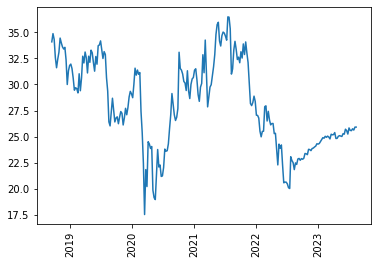

In [135]:
plt.plot(datetime_index.values, np.concatenate((df['close'].values, np.array(future_predictions).ravel())))
plt.xticks(rotation=90)